# Evaluating SimplePromptPipeline

In [2]:
import os
import sys
import json
import pandas as pd
from datetime import datetime

# Add project root (the directory that contains "src")
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- Imports from your project ---
from src.pipelines.SimplePromptPipeline import SimplePromptPipeline
from src.pipelines.SimplePromptPipeline import SimplePromptDescPipeline
from src.app.Evaluator import Evaluator
from src.llms.LLM_Wrappers import AbstractLLM

# --- Define Models to Evaluate ---
models = {
    "GPT-3": AbstractLLM.from_name("gpt-3.5-turbo"),
    "GPT-4o-mini": AbstractLLM.from_name(model_name="gpt-4o-mini"),
    "GPT-4o": AbstractLLM.from_name(model_name="gpt-4o"),
}

# --- Files to Evaluate ---
ground_truth_files = [
    "../src/data/Q17_Annotated_Responses.json",
    # "../src/data/Q19_Annotated_Responses.json",
    # "../src/data/Q20_Annotated_Responses.json",
    # "../src/data/Q21_Annotated_Responses.json",
    # "../src/data/Q22_Annotated_Responses.json",
]

# --- Output and Results Directories ---
output_dir = "../outputs"
os.makedirs(output_dir, exist_ok=True)

results_dir = os.path.join("../analysis", "results")
os.makedirs(results_dir, exist_ok=True)

# --- Parameters ---
min_conf = 0.7
records = []

evaluators = []

# --- Run pipelines + evaluate ---
for model_name, llm in models.items():
    model_suffix = model_name.replace(" ", "_").replace("/", "-")
    print(f"\n=== Running {model_name} ===")
    for gt_path in ground_truth_files:
        qname = os.path.basename(gt_path).replace("_Annotated_Responses.json", "")
        print(f" → Processing {qname}...")

        # Run pipeline
        pipeline = SimplePromptPipeline(
            llm=llm,
            input_path=gt_path,
            output_dir=output_dir,
            output_name=model_suffix+"simple",
        )
        output_path = pipeline.run()

        # Evaluate results
        evaluator = Evaluator(output_path, gt_path)
        results = evaluator.evaluate_precision_recall(min_confidence=min_conf)
        global_metrics = results["global"]

        evaluators.append(evaluator)

        records.append({
            "Model": model_name,
            "Question": qname,
            "Precision": global_metrics["precision"],
            "Recall": global_metrics["recall"],
            "F1-Score": global_metrics["f1-score"],
        })

# --- Build DataFrames ---
df_better = pd.DataFrame(records)
summary_df_better = (
    df_better.groupby("Model")[["Precision", "Recall", "F1-Score"]]
      .mean()
      .reset_index()
      .sort_values("Model")
)

# --- Save Results ---
df_better.to_csv(os.path.join(results_dir, "per_question_results.csv"), index=False)
summary_df_better.to_csv(os.path.join(results_dir, "summary_results.csv"), index=False)


=== Running GPT-3 ===
 → Processing Q17...


Annotating entries: 100%|█████████████████| 58/58 [01:31<00:00,  1.58s/entry, Last: 0.67s]


Annotated JSON written to ../outputs/Q17_Annotated_Responses_GPT-3simple_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251208_095510.log

=== Running GPT-4o-mini ===
 → Processing Q17...


Annotating entries: 100%|█████████████████| 58/58 [01:55<00:00,  1.99s/entry, Last: 1.43s]


Annotated JSON written to ../outputs/Q17_Annotated_Responses_GPT-4o-minisimple_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251208_095641.log

=== Running GPT-4o ===
 → Processing Q17...


Annotating entries: 100%|█████████████████| 58/58 [01:27<00:00,  1.51s/entry, Last: 1.25s]

Annotated JSON written to ../outputs/Q17_Annotated_Responses_GPT-4osimple_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251208_095836.log


In [3]:
# --- Display Results (with graceful fallback if jinja2 missing) ---
print("\n\n=== 📊 Per-Question Results ===")
try:
    display(df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))

print("\n\n=== 🧮 Average Precision/Recall per Model ===")
try:
    display(summary_df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(summary_df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))



=== 📊 Per-Question Results ===


,Model,Question,Precision,Recall,F1-Score
0,GPT-3,Q17,0.537,0.614,0.573
1,GPT-4o-mini,Q17,0.585,0.747,0.656
2,GPT-4o,Q17,0.617,0.699,0.655




=== 🧮 Average Precision/Recall per Model ===


,Model,Precision,Recall,F1-Score
0,GPT-3,0.537,0.614,0.573
1,GPT-4o,0.617,0.699,0.655
2,GPT-4o-mini,0.585,0.747,0.656


## Investigate the evaluations further

In [11]:
eval = evaluators[0]  # Example: inspect the first evaluator

for min_conf in (0.7, 0.8, 0.9):
    metrics = evaluator.evaluate_precision_recall(min_confidence=min_conf)
    print("\n\n=== Evaluation Metrics at min_confidence =", min_conf, "===")
    # I only want to see the global metrics here)
    results = {"global": metrics["global"]}

    print(json.dumps(results, indent=2))
    print("\n")



=== Evaluation Metrics at min_confidence = 0.7 ===
{
  "global": {
    "precision": 0.45652173913043476,
    "recall": 0.7590361445783133,
    "f1-score": 0.5701357466063348
  }
}




=== Evaluation Metrics at min_confidence = 0.8 ===
{
  "global": {
    "precision": 0.45454545454545453,
    "recall": 0.7228915662650602,
    "f1-score": 0.5581395348837209
  }
}




=== Evaluation Metrics at min_confidence = 0.9 ===
{
  "global": {
    "precision": 0.44144144144144143,
    "recall": 0.5903614457831325,
    "f1-score": 0.5051546391752577
  }
}




In [ ]:
import pandas as pd

# Confidence thresholds to test
conf_thresholds = [0.7, 0.8, 0.9]

all_tables = []  # store dataframes for optional later combination

for evaluator in evaluators:
    print("\n" + "=" * 80)
    print(f"📌 Evaluator: {os.path.basename(evaluator.auto_path)}")
    print("=" * 80)

    rows = []

    for conf in conf_thresholds:
        res = evaluator.evaluate_precision_recall(min_confidence=conf)
        g = res["global"]

        rows.append({
            "Min Confidence": conf,
            "Precision": g["precision"],
            "Recall": g["recall"],
            "F1-Score": g["f1-score"],
        })

    df_better = pd.DataFrame(rows)
    all_tables.append((evaluator, df_better))

    # Pretty print table
    print(df_better.to_string(index=False, formatters={
        "Precision": "{:.3f}".format,
        "Recall": "{:.3f}".format,
        "F1-Score": "{:.3f}".format,
    }))
    print("\n")



📌 Evaluator: Q17_Annotated_Responses_GPT-3_annotated.json
 Min Confidence Precision Recall F1-Score
            0.7     0.362  0.602    0.452
            0.8     0.362  0.554    0.438
            0.9     0.293  0.325    0.309



📌 Evaluator: Q17_Annotated_Responses_GPT-4o-mini_annotated.json
 Min Confidence Precision Recall F1-Score
            0.7     0.417  0.759    0.538
            0.8     0.415  0.675    0.514
            0.9     0.360  0.386    0.372



📌 Evaluator: Q17_Annotated_Responses_GPT-4o_annotated.json
 Min Confidence Precision Recall F1-Score
            0.7     0.457  0.759    0.570
            0.8     0.455  0.723    0.558
            0.9     0.441  0.590    0.505




## Calculate the distribution of different confidence values

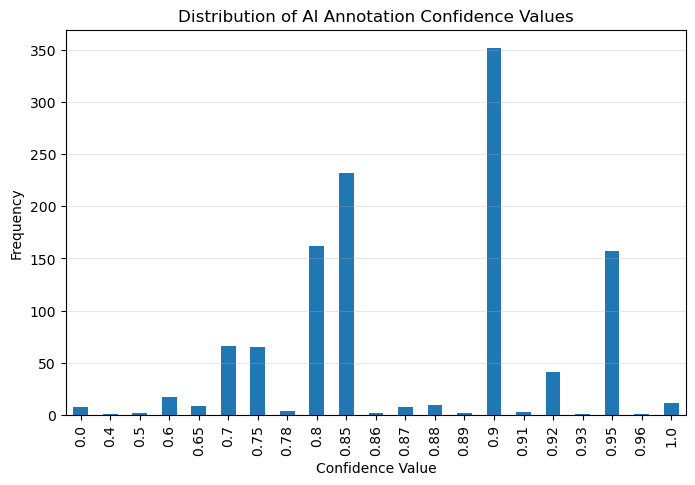

In [6]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------
# Collect confidence values from all outputs
# -----------------------------------------

confidence_values = []

# Find all annotated files in outputs/
for path in glob.glob(os.path.join(output_dir, "*_annotated.json")):
    with open(path, "r") as f:
        data = json.load(f)

    for ans in data["answers"]:
        annotations = ans.get("annotations", {})
        for theme, codes in annotations.items():
            if theme == "No Responses":
                continue

            for code_name, instance in codes.items():

                # Only count AI-generated annotations
                annotator = instance.get("annotator", "")
                if annotator.lower() == "human":
                    continue

                conf = instance.get("confidence", None)
                if conf is not None:
                    confidence_values.append(float(conf))

# -----------------------------------------
# Build DataFrame
# -----------------------------------------

conf_df = pd.DataFrame(confidence_values, columns=["confidence"])

# Optional: round to bins (e.g., 0.1 intervals)
# conf_df["confidence_bin"] = conf_df["confidence"].round(1)

# -----------------------------------------
# Plot distribution
# -----------------------------------------

plt.figure(figsize=(8, 5))
conf_df["confidence"].value_counts().sort_index().plot(
    kind="bar"
)

plt.title("Distribution of AI Annotation Confidence Values")
plt.xlabel("Confidence Value")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.3)

plt.show()


# Evaluate SimplePromptPipeline with Descriptions

In [3]:
# --- Run pipelines + evaluate (with descriptions) ---
records_desc = []

for model_name, llm in models.items():
    print(f"\n=== Running {model_name} (with Descriptions) ===")
    for gt_path in ground_truth_files:
        qname = os.path.basename(gt_path).replace("_Annotated_Responses.json", "")
        print(f" → Processing {qname}...")

        # Run descriptive pipeline
        pipeline = SimplePromptDescPipeline(llm=llm, input_path=gt_path, output_dir=output_dir)
        maybe_path = pipeline.run()

        # Create model-specific filename
        model_suffix = model_name.replace(" ", "_").replace("/", "-")
        base_name = os.path.splitext(os.path.basename(gt_path))[0]
        model_output_name = f"{base_name}_{model_suffix}_desc_annotated.json"
        output_path = os.path.join(output_dir, model_output_name)

        # If pipeline didn’t save under that exact name, rename the generic one
        if not os.path.exists(output_path):
            generic_output = os.path.join(output_dir, f"{base_name}_annotated.json")
            if os.path.exists(generic_output):
                os.rename(generic_output, output_path)
            else:
                raise FileNotFoundError(f"Expected output file not found: {output_path}")

        # Evaluate results
        evaluator = Evaluator(output_path, gt_path)
        results = evaluator.evaluate_precision_recall(min_confidence=min_conf)
        global_metrics = results["global"]

        records_desc.append({
            "Model": model_name,
            "Question": qname,
            "Precision": global_metrics["precision"],
            "Recall": global_metrics["recall"],
            "F1-Score": global_metrics["f1-score"],
            "Mode": "Desc"  # mark these runs
        })

# --- Build DataFrames ---
df_desc = pd.DataFrame(records_desc)
summary_df_desc = (
    df_desc.groupby("Model")[["Precision", "Recall", "F1-Score"]]
           .mean()
           .reset_index()
           .sort_values("Model")
)

# --- Save Results ---
df_desc.to_csv(os.path.join(results_dir, "per_question_results_desc.csv"), index=False)
summary_df_desc.to_csv(os.path.join(results_dir, "summary_results_desc.csv"), index=False)

print("\n✅ Evaluations with code descriptions completed successfully!")



=== Running GPT-3 (with Descriptions) ===
 → Processing Q17...


Annotating entries:   0%|                                      | 0/104 [00:00<?, ?entry/s]

Annotating entries: 100%|███████████████| 104/104 [01:15<00:00,  1.38entry/s, Last: 1.00s]


Annotated JSON written to ../outputs/Q17_Annotated_Responses_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251109_141904.log

=== Running GPT-4o-mini (with Descriptions) ===
 → Processing Q17...


Annotating entries: 100%|███████████████| 104/104 [02:19<00:00,  1.34s/entry, Last: 1.53s]


Annotated JSON written to ../outputs/Q17_Annotated_Responses_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251109_142019.log

=== Running GPT-4o (with Descriptions) ===
 → Processing Q17...


Annotating entries: 100%|███████████████| 104/104 [01:54<00:00,  1.11s/entry, Last: 0.91s]

Annotated JSON written to ../outputs/Q17_Annotated_Responses_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251109_142238.log

✅ Evaluations with code descriptions completed successfully!


In [5]:
# --- Display Results (with graceful fallback if jinja2 missing) ---
print("\n\n=== 📊 Per-Question Results ===")
try:
    display(df_desc.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(df_desc.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))

print("\n\n=== 🧮 Average Precision/Recall per Model ===")
try:
    display(summary_df_desc.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(summary_df_desc.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))



=== 📊 Per-Question Results ===


,Model,Question,Precision,Recall,F1-Score,Mode
0,GPT-3,Q17,0.400,0.651,0.495,Desc
1,GPT-4o-mini,Q17,0.415,0.819,0.551,Desc
2,GPT-4o,Q17,0.441,0.759,0.558,Desc




=== 🧮 Average Precision/Recall per Model ===


,Model,Precision,Recall,F1-Score
0,GPT-3,0.400,0.651,0.495
1,GPT-4o,0.441,0.759,0.558
2,GPT-4o-mini,0.415,0.819,0.551


In [ ]:
import os
import sys
import json
import pandas as pd
from datetime import datetime

# Add project root (the directory that contains "src")
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- Imports from your project ---
from src.pipelines.SimplePromptPipeline import SimplePromptPipeline
from src.pipelines.SimplePromptPipeline import SimplePromptDescPipeline
from src.app.Evaluator import Evaluator
from src.llms.LLM_Wrappers import AbstractLLM

# --- Define Models to Evaluate ---
models = {
    "GPT-3": AbstractLLM.from_name("gpt-3.5-turbo"),
    "GPT-4o": AbstractLLM.from_name(model_name="gpt-4o"),
    "qwen3:4b": AbstractLLM.from_name(model_name="qwen3:4b"),
}

# --- Files to Evaluate ---
ground_truth_files = [
    # "../src/data/Q17_Annotated_Responses.json",
    "../src/data/Q19_Annotated_Responses.json",
    # "../src/data/Q20_Annotated_Responses.json",
    # "../src/data/Q21_Annotated_Responses.json",
    # "../src/data/Q22_Annotated_Responses.json",
]

# --- Output and Results Directories ---
output_dir = "../outputs"
os.makedirs(output_dir, exist_ok=True)

results_dir = os.path.join("../analysis", "results")
os.makedirs(results_dir, exist_ok=True)

# --- Parameters ---
min_conf = 0.7
records = []

# --- Run pipelines + evaluate ---
for model_name, llm in models.items():
    print(f"\n=== Running {model_name} ===")
    for gt_path in ground_truth_files:
        qname = os.path.basename(gt_path).replace("_Annotated_Responses.json", "")
        print(f" → Processing {qname}...")

        # Run pipeline
        pipeline = SimplePromptPipeline(llm=llm, input_path=gt_path, output_dir=output_dir)
        maybe_path = pipeline.run()

        # Create model-specific filename
        model_suffix = model_name.replace(" ", "_").replace("/", "-")
        base_name = os.path.splitext(os.path.basename(gt_path))[0]
        model_output_name = f"{base_name}_{model_suffix}_annotated.json"
        output_path = os.path.join(output_dir, model_output_name)

        # If pipeline didn't create that, rename existing _annotated.json file if present
        if not os.path.exists(output_path):
            generic_output = os.path.join(output_dir, f"{base_name}_annotated.json")
            if os.path.exists(generic_output):
                os.rename(generic_output, output_path)
            else:
                raise FileNotFoundError(f"Expected output file not found: {output_path}")

        # Evaluate results
        evaluator = Evaluator(output_path, gt_path)
        results = evaluator.evaluate_precision_recall(min_confidence=min_conf)
        global_metrics = results["global"]

        records.append({
            "Model": model_name,
            "Question": qname,
            "Precision": global_metrics["precision"],
            "Recall": global_metrics["recall"],
            "F1-Score": global_metrics["f1-score"],
        })

# --- Build DataFrames ---
df_better = pd.DataFrame(records)
summary_df_better = (
    df_better.groupby("Model")[["Precision", "Recall", "F1-Score"]]
      .mean()
      .reset_index()
      .sort_values("Model")
)

# --- Save Results ---
df_better.to_csv(os.path.join(results_dir, "per_question_results.csv"), index=False)
summary_df_better.to_csv(os.path.join(results_dir, "summary_results.csv"), index=False)

# --- 

# --- Run pipelines + evaluate (with descriptions) ---
records_desc = []

for model_name, llm in models.items():
    print(f"\n=== Running {model_name} (with Descriptions) ===")
    for gt_path in ground_truth_files:
        qname = os.path.basename(gt_path).replace("_Annotated_Responses.json", "")
        print(f" → Processing {qname}...")

        # Run descriptive pipeline
        pipeline = SimplePromptDescPipeline(llm=llm, input_path=gt_path, output_dir=output_dir)
        maybe_path = pipeline.run()

        # Create model-specific filename
        model_suffix = model_name.replace(" ", "_").replace("/", "-")
        base_name = os.path.splitext(os.path.basename(gt_path))[0]
        model_output_name = f"{base_name}_{model_suffix}_desc_annotated.json"
        output_path = os.path.join(output_dir, model_output_name)

        # If pipeline didn’t save under that exact name, rename the generic one
        if not os.path.exists(output_path):
            generic_output = os.path.join(output_dir, f"{base_name}_annotated.json")
            if os.path.exists(generic_output):
                os.rename(generic_output, output_path)
            else:
                raise FileNotFoundError(f"Expected output file not found: {output_path}")

        # Evaluate results
        evaluator = Evaluator(output_path, gt_path)
        results = evaluator.evaluate_precision_recall(min_confidence=min_conf)
        global_metrics = results["global"]

        records_desc.append({
            "Model": model_name,
            "Question": qname,
            "Precision": global_metrics["precision"],
            "Recall": global_metrics["recall"],
            "F1-Score": global_metrics["f1-score"],
            "Mode": "Desc"  # mark these runs
        })

# --- Build DataFrames ---
df_desc = pd.DataFrame(records_desc)
summary_df_desc = (
    df_desc.groupby("Model")[["Precision", "Recall", "F1-Score"]]
           .mean()
           .reset_index()
           .sort_values("Model")
)

# --- Save Results ---
df_desc.to_csv(os.path.join(results_dir, "per_question_results_desc.csv"), index=False)
summary_df_desc.to_csv(os.path.join(results_dir, "summary_results_desc.csv"), index=False)

print("\n✅ Evaluations with code descriptions completed successfully!")

# --- Display Results (with graceful fallback if jinja2 missing) ---
print("\n\n=== 📊 Per-Question Results ===")
try:
    display(df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
    display(df_desc.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))
    print(df_desc.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))

print("\n\n=== 🧮 Average Precision/Recall per Model ===")
try:
    display(summary_df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
    display(summary_df_desc.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(summary_df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))
    print(summary_df_desc.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))


=== Running GPT-3 ===
 → Processing Q19...


Annotating entries:   0%|                                      | 0/105 [00:00<?, ?entry/s]

Annotating entries: 100%|███████████████| 105/105 [01:21<00:00,  1.29entry/s, Last: 0.82s]


Annotated JSON written to ../outputs/Q19_Annotated_Responses_annotated.json
Logs saved to logs/Q19_Annotated_Responses_20251109_153216.log

=== Running GPT-4o ===
 → Processing Q19...


Annotating entries: 100%|███████████████| 105/105 [01:54<00:00,  1.09s/entry, Last: 0.82s]


Annotated JSON written to ../outputs/Q19_Annotated_Responses_annotated.json
Logs saved to logs/Q19_Annotated_Responses_20251109_153337.log

=== Running qwen3:4b ===
 → Processing Q19...


Annotating entries: 100%|████████████| 105/105 [1:30:22<00:00, 51.64s/entry, Last: 65.34s]


Annotated JSON written to ../outputs/Q19_Annotated_Responses_annotated.json
Logs saved to logs/Q19_Annotated_Responses_20251109_153531.log

=== Running GPT-3 (with Descriptions) ===
 → Processing Q19...


Annotating entries: 100%|███████████████| 105/105 [01:23<00:00,  1.26entry/s, Last: 1.02s]


Annotated JSON written to ../outputs/Q19_Annotated_Responses_annotated.json
Logs saved to logs/Q19_Annotated_Responses_20251109_170553.log

=== Running GPT-4o (with Descriptions) ===
 → Processing Q19...


Annotating entries: 100%|███████████████| 105/105 [02:16<00:00,  1.30s/entry, Last: 1.23s]


Annotated JSON written to ../outputs/Q19_Annotated_Responses_annotated.json
Logs saved to logs/Q19_Annotated_Responses_20251109_170716.log

=== Running qwen3:4b (with Descriptions) ===
 → Processing Q19...


Annotating entries:   0%|                                      | 0/105 [00:00<?, ?entry/s]

# Evaluating SimplePrompt Variations

## Testing if adding Question helps

In [6]:
import os
import sys
import json
import pandas as pd
from datetime import datetime

# Add project root (the directory that contains "src")
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- Imports from your project ---
from src.pipelines.SimplePromptPipeline import SimplePromptPipeline
from src.pipelines.SimplePromptPipeline import SimplePromptDescPipeline
from src.app.Evaluator import Evaluator
from src.llms.LLM_Wrappers import AbstractLLM

# --- Define Models to Evaluate ---
models = {
    # "GPT-3": AbstractLLM.from_name("gpt-3.5-turbo"),
    "GPT-4o-mini": AbstractLLM.from_name(model_name="gpt-4o-mini"),
    # "GPT-4o": AbstractLLM.from_name(model_name="gpt-4o"),
}

# --- Files to Evaluate ---
ground_truth_files = [
    "../src/data/Q17_Annotated_Responses.json",
    # "../src/data/Q19_Annotated_Responses.json",
    # "../src/data/Q20_Annotated_Responses.json",
    # "../src/data/Q21_Annotated_Responses.json",
    # "../src/data/Q22_Annotated_Responses.json",
]

# --- Output and Results Directories ---
output_dir = "../outputs"
os.makedirs(output_dir, exist_ok=True)

results_dir = os.path.join("../analysis", "results")
os.makedirs(results_dir, exist_ok=True)

# --- Parameters ---
min_conf = 0.7
records = []

evaluators = []

# --- Run pipelines + evaluate ---
for model_name, llm in models.items():
    print(f"\n=== Running {model_name} ===")
    for gt_path in ground_truth_files:
        qname = os.path.basename(gt_path).replace("_Annotated_Responses.json", "")
        print(f" → Processing {qname}...")

        # Run pipeline
        pipeline = SimplePromptPipeline(llm=llm, input_path=gt_path, output_dir=output_dir, use_cache=False)
        maybe_path = pipeline.run()

        # Create model-specific filename
        model_suffix = model_name.replace(" ", "_").replace("/", "-")
        base_name = os.path.splitext(os.path.basename(gt_path))[0]
        model_output_name = f"{base_name}_{model_suffix}_annotated.json"
        output_path = os.path.join(output_dir, model_output_name)

        # If pipeline didn't create that, rename existing _annotated.json file if present
        if not os.path.exists(output_path):
            generic_output = os.path.join(output_dir, f"{base_name}_annotated.json")
            if os.path.exists(generic_output):
                os.rename(generic_output, output_path)
            else:
                raise FileNotFoundError(f"Expected output file not found: {output_path}")

        # Evaluate results
        evaluator = Evaluator(output_path, gt_path)
        results = evaluator.evaluate_precision_recall(min_confidence=min_conf)
        global_metrics = results["global"]

        evaluators.append(evaluator)

        records.append({
            "Model": model_name,
            "Question": qname,
            "Precision": global_metrics["precision"],
            "Recall": global_metrics["recall"],
            "F1-Score": global_metrics["f1-score"],
        })

# --- Build DataFrames ---
df_better = pd.DataFrame(records)
summary_df_better = (
    df_better.groupby("Model")[["Precision", "Recall", "F1-Score"]]
      .mean()
      .reset_index()
      .sort_values("Model")
)

# --- Save Results ---
df_better.to_csv(os.path.join(results_dir, "per_question_results.csv"), index=False)
summary_df_better.to_csv(os.path.join(results_dir, "summary_results.csv"), index=False)


=== Running GPT-4o-mini ===
 → Processing Q17...


Annotating entries: 100%|███████████████| 104/104 [02:09<00:00,  1.24s/entry, Last: 2.55s]

Annotated JSON written to ../outputs/Q17_Annotated_Responses_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251124_090100.log


In [7]:
print(summary_df_better)

         Model  Precision    Recall  F1-Score
0  GPT-4o-mini   0.403846  0.759036  0.527197


In [8]:
# --- Display Results (with graceful fallback if jinja2 missing) ---
print("\n\n=== 📊 Per-Question Results ===")
try:
    display(df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))

print("\n\n=== 🧮 Average Precision/Recall per Model ===")
try:
    display(summary_df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(summary_df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))



=== 📊 Per-Question Results ===


,Model,Question,Precision,Recall,F1-Score
0,GPT-4o-mini,Q17,0.404,0.759,0.527




=== 🧮 Average Precision/Recall per Model ===


,Model,Precision,Recall,F1-Score
0,GPT-4o-mini,0.404,0.759,0.527


## Test BetterPromptPipeline

In [11]:
import os
import sys
import json
import pandas as pd
from datetime import datetime

# Add project root (the directory that contains "src")
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# --- Imports from your project ---
from src.pipelines.BetterPromptPipeline import BetterPromptDescPipeline
from src.app.Evaluator import Evaluator
from src.llms.LLM_Wrappers import AbstractLLM

# --- Define Models to Evaluate ---
models = {
    "GPT-3": AbstractLLM.from_name("gpt-3.5-turbo"),
    "GPT-4o-mini": AbstractLLM.from_name(model_name="gpt-4o-mini"),
    "GPT-4o": AbstractLLM.from_name(model_name="gpt-4o"),
}

# --- Files to Evaluate ---
ground_truth_files = [
    "../src/data/Q17_Annotated_Responses.json",
    # "../src/data/Q19_Annotated_Responses.json",
    # "../src/data/Q20_Annotated_Responses.json",
    # "../src/data/Q21_Annotated_Responses.json",
    # "../src/data/Q22_Annotated_Responses.json",
]

# --- Output and Results Directories ---
output_dir = "../outputs"
os.makedirs(output_dir, exist_ok=True)

results_dir = os.path.join("../analysis", "results")
os.makedirs(results_dir, exist_ok=True)

# --- Parameters ---
min_conf = 0.7
records = []

evaluators = []

# --- Run pipelines + evaluate ---
for model_name, llm in models.items():
    model_suffix = model_name.replace(" ", "_").replace("/", "-")
    print(f"\n=== Running {model_name} ===")
    for gt_path in ground_truth_files:
        qname = os.path.basename(gt_path).replace("_Annotated_Responses.json", "")
        print(f" → Processing {qname}...")

        # Run pipeline

        pipeline = BetterPromptDescPipeline(
            llm=llm,
            input_path=gt_path,
            output_dir=output_dir,
            output_name=model_suffix,
        )
        output_path = pipeline.run()


        # Evaluate results
        evaluator = Evaluator(output_path, gt_path)
        results = evaluator.evaluate_precision_recall(min_confidence=min_conf)
        global_metrics = results["global"]

        evaluators.append(evaluator)

        records.append({
            "Model": model_name,
            "Question": qname,
            "Precision": global_metrics["precision"],
            "Recall": global_metrics["recall"],
            "F1-Score": global_metrics["f1-score"],
        })

# --- Build DataFrames ---
df_better = pd.DataFrame(records)
summary_df_better = (
    df_better.groupby("Model")[["Precision", "Recall", "F1-Score"]]
      .mean()
      .reset_index()
      .sort_values("Model")
)

# --- Save Results ---
df_better.to_csv(os.path.join(results_dir, "per_question_results.csv"), index=False)
summary_df_better.to_csv(os.path.join(results_dir, "summary_results.csv"), index=False)


=== Running GPT-3 ===
 → Processing Q17...


Annotating entries: 100%|███████████████| 104/104 [01:04<00:00,  1.62entry/s, Last: 1.02s]


Annotated JSON written to ../outputs/Q17_Annotated_Responses_GPT-3_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251124_093644.log

=== Running GPT-4o-mini ===
 → Processing Q17...


Annotating entries: 100%|███████████████| 104/104 [04:06<00:00,  2.37s/entry, Last: 2.05s]


Annotated JSON written to ../outputs/Q17_Annotated_Responses_GPT-4o-mini_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251124_093748.log

=== Running GPT-4o ===
 → Processing Q17...


Annotating entries: 100%|███████████████| 104/104 [02:33<00:00,  1.48s/entry, Last: 2.55s]

Annotated JSON written to ../outputs/Q17_Annotated_Responses_GPT-4o_annotated.json
Logs saved to logs/Q17_Annotated_Responses_20251124_094154.log


In [12]:
# --- Display Results (with graceful fallback if jinja2 missing) ---
print("\n\n=== 📊 Per-Question Results ===")
try:
    display(df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))

print("\n\n=== 🧮 Average Precision/Recall per Model ===")
try:
    display(summary_df_better.style.format({"Precision": "{:.3f}", "Recall": "{:.3f}", "F1-Score": "{:.3f}"}))
except AttributeError:
    print(summary_df_better.to_string(index=False, formatters={"Precision": "{:.3f}".format, "Recall": "{:.3f}".format, "F1-Score": "{:.3f}".format}))



=== 📊 Per-Question Results ===


,Model,Question,Precision,Recall,F1-Score
0,GPT-3,Q17,0.410,0.578,0.480
1,GPT-4o-mini,Q17,0.394,0.735,0.513
2,GPT-4o,Q17,0.408,0.590,0.483




=== 🧮 Average Precision/Recall per Model ===


,Model,Precision,Recall,F1-Score
0,GPT-3,0.410,0.578,0.480
1,GPT-4o,0.408,0.590,0.483
2,GPT-4o-mini,0.394,0.735,0.513
